In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.io as sio
import copy
import pylab as pl
import time
from IPython import display

## Chirp parameters

In [2]:
start_freq = 770000
band_freq = 120000
duration = 0.0004
samples_one_second = 10000000
rate = samples_one_second / start_freq
sample = start_freq * rate
npnts = int(sample * duration)
print("Smpale per cicle", rate, "Sample for one second", samples_one_second, "Total semples", npnts)

Smpale per cicle 12.987012987012987 Sample for one second 10000000 Total semples 4000


## Create the chirp

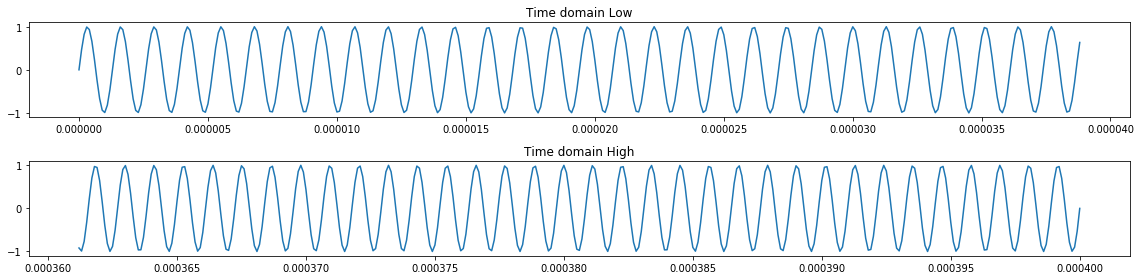

In [18]:
timevec = np.linspace(0, duration, npnts)
adding_freq = np.linspace(0, band_freq, npnts)

# chirp = np.sin(2*np.pi * (start_freq) * timevec)
chirp = np.sin(2*np.pi * (start_freq + adding_freq * 0.5) * timevec)
# chirp = signal.chirp(timevec,f0=start_freq,t1=duration,f1=start_freq + band_freq)

ciclestoshow = int(rate * 30)


plt.figure(figsize=(16,4))

plt.subplot(211)
plt.plot(timevec[:ciclestoshow], chirp[:ciclestoshow])
plt.title("Time domain Low")

plt.subplot(212)
plt.plot(timevec[-ciclestoshow:], chirp[-ciclestoshow:])
plt.title("Time domain High")
plt.tight_layout()
plt.show()

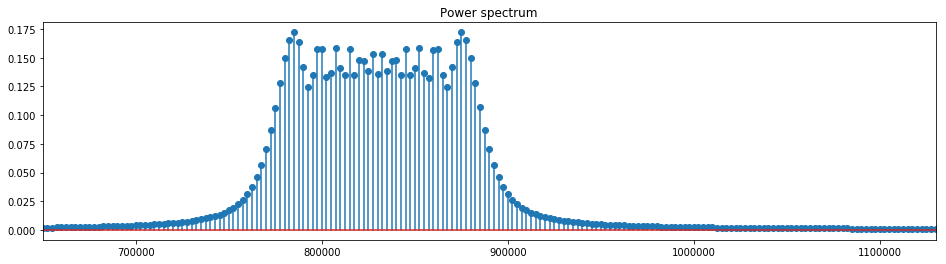

In [11]:
hz = np.linspace(0, sample / 2, int(np.floor(npnts / 2) + 1))
spectrum = 2*np.abs(scipy.fftpack.fft(chirp)) / npnts


plt.figure(figsize=(16,4))
plt.stem(hz,spectrum[0:len(hz)])
plt.xlim([start_freq - band_freq,start_freq + band_freq*3])
plt.title('Power spectrum')
plt.show()

## Distance of an object in km

In [12]:
kilometer = 8
kilometer2 = 16

## RX TX Chirp Mix of 2 object

Theoretical max distance of a chirp of 60.0 km
smallest measure distance 0.015 km
shift 533 out of 4000 sample points, for a distance of 7.995 km

shift2 1066 out of 4000 sample points, for a distance of 15.99 km

Friquncy domain per distance 0.0005 km per herz


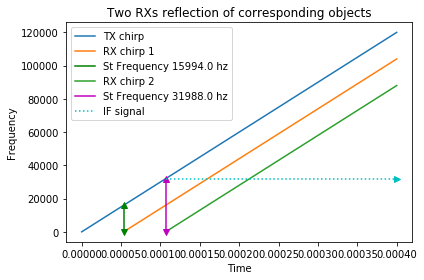

In [26]:
light_speed_km = 300000
print('Theoretical max distance of a chirp of', light_speed_km * duration / 2, 'km')
smallest_measure_distance = light_speed_km * (1 / samples_one_second) / 2
print('smallest measure distance',smallest_measure_distance, 'km')

shift = int((1 / smallest_measure_distance) * kilometer)
print('shift', shift, 'out of', npnts, 'sample points, for a distance of', np.round(shift * smallest_measure_distance, 3), 'km')
print()

shift2 = int((1 / smallest_measure_distance) * kilometer2)
print('shift2', shift2, 'out of', npnts, 'sample points, for a distance of', np.round(shift2 * smallest_measure_distance, 3), 'km')

print()
distance_per_herz = (light_speed_km * duration / 2) / band_freq
print('Friquncy domain per distance', distance_per_herz, 'km per herz')

chirp_time = np.linspace(0, duration, npnts)
chirp_freq = np.linspace(0, band_freq, npnts)
plt.plot(chirp_time, chirp_freq, label='TX chirp')

plt.plot(chirp_time[shift:], chirp_freq[:-shift], label='RX chirp 1')
plt.plot([chirp_time[shift],chirp_time[shift]], [0,chirp_freq[shift]], 'g-' , label='St Frequency {} hz'.format(np.round(chirp_freq[shift])))
plt.plot(chirp_time[shift],0, 'gv')
plt.plot(chirp_time[shift],chirp_freq[shift], 'g^')

plt.plot(chirp_time[shift2:], chirp_freq[:-shift2], label='RX chirp 2')
plt.plot([chirp_time[shift2],chirp_time[shift2]], [0,chirp_freq[shift2]], 'm-' , label='St Frequency {} hz'.format(np.round(chirp_freq[shift2])))
plt.plot(chirp_time[shift2],0, 'mv')
plt.plot(chirp_time[shift2],chirp_freq[shift2], 'm^')
plt.plot([chirp_time[shift2],chirp_time[-1]],[chirp_freq[shift2],chirp_freq[shift2]], 'c:', label='IF signal')
plt.plot([chirp_time[-1]],[chirp_freq[shift2]], 'c>')

plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Two RXs reflection of corresponding objects')


plt.legend()
plt.tight_layout()
plt.show()

## Two objects detection

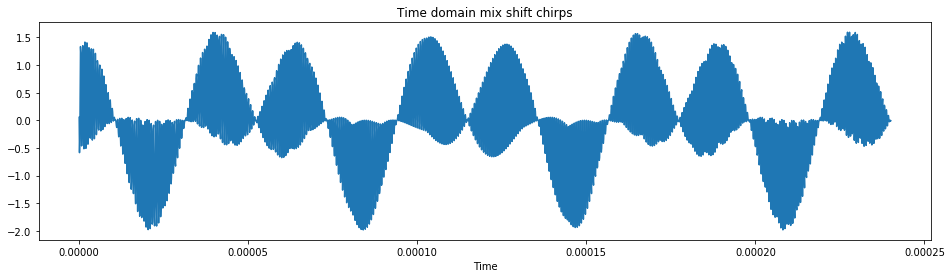

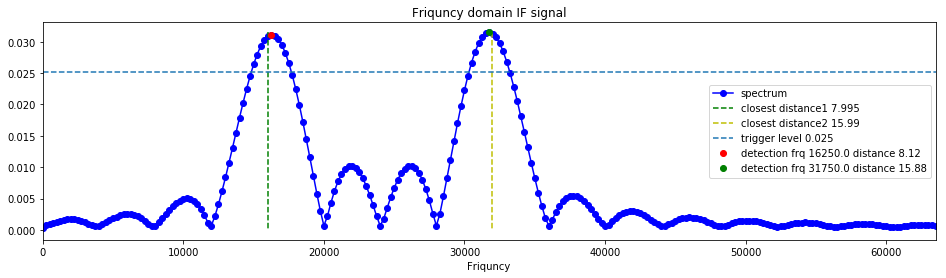

In [23]:
# local synthesizer
tx = chirp[shift + shift2:]
# First object reflection signal
rx1 = chirp[:-(shift + shift2)]
# Second object reflection signal
rx2 = chirp[shift2:-shift]

# mixing all frequencies
mix = tx * rx2 + rx1 * rx2#tx * rx1 + 

plt.figure(figsize=(16,4))
plt.plot(timevec[:-(shift + shift2)], mix)
plt.title("Time domain mix shift chirps")
plt.xlabel('Time')
plt.show()

accuracy = int(npnts * 10)

hz = np.linspace(0, sample / 2, int(np.floor(accuracy / 2) + 1))

# Get IF frequencies spectrum
fftmix = scipy.fftpack.fft(mix, n=accuracy)
ifSpectrum = np.abs(fftmix) / accuracy
ifSpectrum[1:] = ifSpectrum[1:] * 2

# Find local high as detection
hz_band_freq = hz[hz <= band_freq]
testIifSpectrum = ifSpectrum[:len(hz_band_freq)]
localMax = np.squeeze(np.where( np.diff(np.sign(np.diff(testIifSpectrum))) < 0)[0]) + 1

# Adjust trigger level
meanMax = testIifSpectrum[localMax].mean()
maxSpectrum = testIifSpectrum[localMax].max()
trigger = maxSpectrum * 0.8

# Detection frequency
valid_local_indexs = localMax[testIifSpectrum[localMax] > trigger]

colors = ['r','g','c','m','y']

plt.figure(figsize=(16,4))
plt.plot(hz_band_freq, testIifSpectrum,'b-o',  label='spectrum')

# Convert chirp shift to distance
dist = smallest_measure_distance * shift
# Convert distance to frequency
scale = dist / distance_per_herz
plt.plot([scale,scale], [maxSpectrum, 0],'g--',  label='closest distance1 {}'.format(np.round(dist,3)))

# Convert chirp shift to distance
dist = smallest_measure_distance * shift2
# Convert distance to frequency
scale = dist / distance_per_herz
plt.plot([scale,scale], [maxSpectrum, 0],'y--',  label='closest distance2 {}'.format(np.round(dist,3)))


plt.plot([hz_band_freq[0],hz_band_freq[-1]],[trigger,trigger],'--',label='trigger level {}'.format(np.round(trigger,3)))
for i in range(len(valid_local_indexs)):
    pos = valid_local_indexs[i]
    freq = hz_band_freq[pos]
    spect_val = testIifSpectrum[pos]
    plt.plot(freq, spect_val,colors[i % len(colors)] + 'o', 
             label='detection frq {} distance {}'.format(freq, np.round(freq * distance_per_herz, 2)))
    
plt.xlim([0,hz[valid_local_indexs[-1]] * 2])
plt.title("Friquncy domain IF signal")
plt.xlabel('Friquncy')
plt.legend()
plt.show()


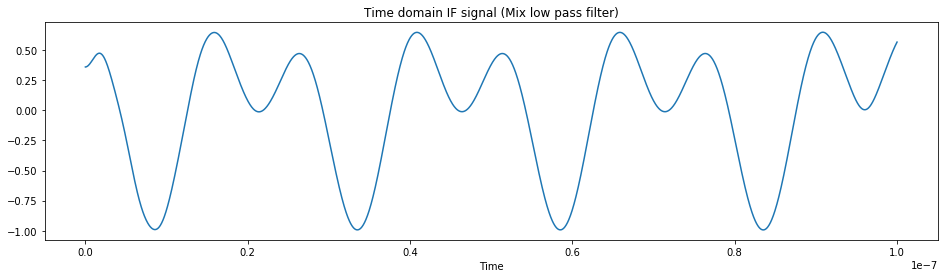

In [25]:
# Low pass filter mixed IF
lowCut = band_freq * 1.2
nyquist = sample/2
transw  = .1
order = npnts

# To avoid edge effect
longmix = np.concatenate((mix[::-1],mix,mix[::-1]))


# order must be odd
if order%2==0:
    order += 1

shape = [ 1, 1, 0, 0 ]
frex  = [ 0, lowCut-lowCut*transw, lowCut, nyquist ]

# define filter shape
# filter kernel
filtkern = signal.firls(order,frex,shape,fs=sample)
filtkern = filtkern * np.hanning(order)

nConv = len(filtkern) + len(longmix) - 1
lenfilter = len(filtkern)
half_filt_len = int(np.floor(lenfilter / 2))

filtkernFft = scipy.fftpack.fft(filtkern,n=nConv)

rowFft = scipy.fftpack.fft(longmix,n=nConv)
ifSignal = np.real(scipy.fftpack.ifft(rowFft * filtkernFft))
ifSignal = ifSignal[half_filt_len:-half_filt_len]
ifSignal = ifSignal[len(mix):-len(mix)+100]

siglen = len(ifSignal)

plt.figure(figsize=(16,4))
plt.plot(timevec[:siglen] * duration, ifSignal)
plt.title("Time domain IF signal (Mix low pass filter)")
plt.xlabel('Time')
plt.show()
